In [12]:
# Import Libraries
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from itertools import product

In [13]:
# Load datasets
item_categories = pd.read_csv('/Users/datpro/Documents/gitdatpro/data-analysis-python-projects/predict-future-sales/datasets/item_categories.csv')
shops = pd.read_csv('/Users/datpro/Documents/gitdatpro/data-analysis-python-projects/predict-future-sales/datasets/shops.csv')
sample_submission = pd.read_csv('/Users/datpro/Documents/gitdatpro/data-analysis-python-projects/predict-future-sales/datasets/sample_submission.csv')
train_data = pd.read_csv('/Users/datpro/Documents/gitdatpro/data-analysis-python-projects/predict-future-sales/datasets/sales_train.csv')
items = pd.read_csv('/Users/datpro/Documents/gitdatpro/data-analysis-python-projects/predict-future-sales/datasets/items.csv')
# set index to ID to avoid droping it later
test_data = pd.read_csv('/Users/datpro/Documents/gitdatpro/data-analysis-python-projects/predict-future-sales/datasets/test.csv').set_index('ID')

/var/folders/6q/33ssnk0j73sg90b2sbyf6_740000gn/T/ipykernel_8793/2418666953.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_sales, x=monthly_sales.index, y='Monthly_Sales', palette=sns.color_palette("husl", 9))
/var/folders/6q/33ssnk0j73sg90b2sbyf6_740000gn/T/ipykernel_8793/2418666953.py:13: UserWarning: 
The palette list has fewer values (9) than needed (34) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=monthly_sales, x=monthly_sales.index, y='Monthly_Sales', palette=sns.color_palette("husl", 9))


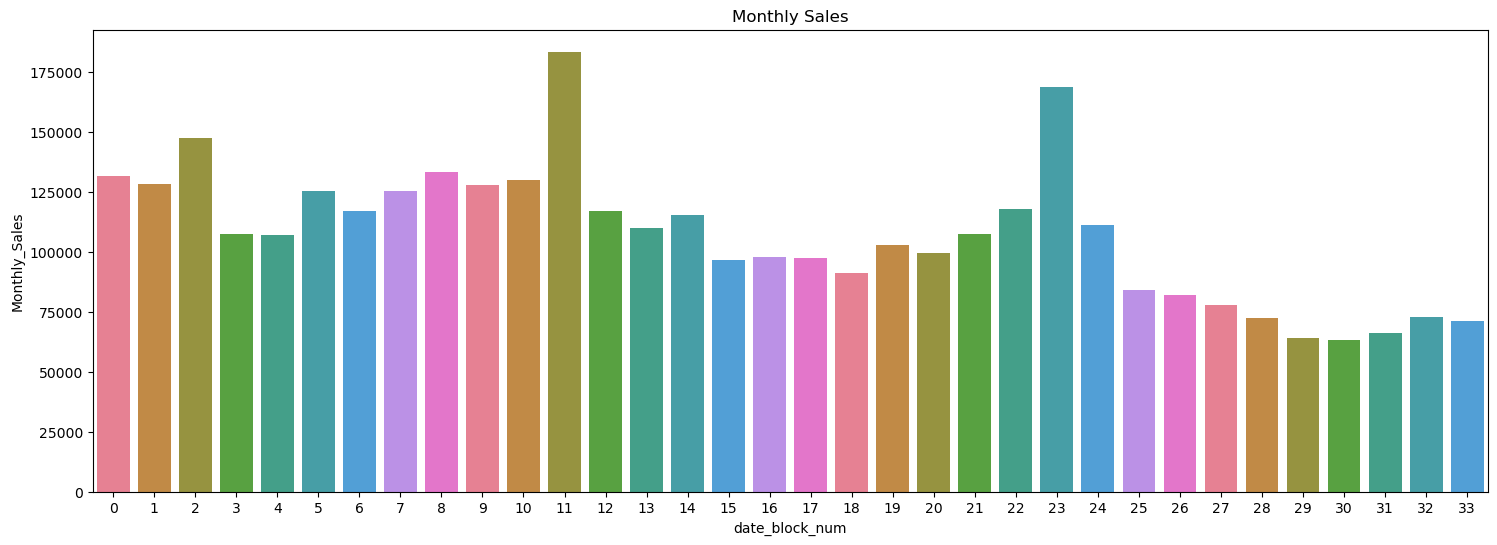

In [9]:
# Date conversion
train_data['date'] = pd.to_datetime(train_data['date'], format='%d.%m.%Y')

# Summary statistics
train_data.describe()

# Plotting sales over time
monthly_sales = train_data.groupby(['date_block_num']).agg({'item_cnt_day':'sum'})
monthly_sales.rename(columns={'item_cnt_day':'Monthly_Sales'}, inplace=True)

plt.figure(figsize=(18,6))
plt.title('Monthly Sales')
sns.barplot(data=monthly_sales, x=monthly_sales.index, y='Monthly_Sales', palette=sns.color_palette("husl", 9))
plt.show()


In [10]:
# Removing negative values
train_data = train_data[train_data['item_price'] >= 0]
train_data = train_data[train_data['item_cnt_day'] >= 0]

# Removing outliers
train_data = train_data[train_data['item_price'] <= 50000]
train_data = train_data[train_data['item_cnt_day'] <= 1000]

train_data.describe()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2928488,2.928488e+06,2.928488e+06,2.928488e+06,2.928488e+06,2.928488e+06
mean,2014-04-03 05:39:46.766140160,1.456976e+01,3.300298e+01,1.020028e+04,8.893252e+02,1.247597e+00
min,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,1.000000e+00
25%,2013-08-01 00:00:00,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00
50%,2014-03-04 00:00:00,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00
75%,2014-12-05 00:00:00,2.300000e+01,4.700000e+01,1.569100e+04,9.990000e+02,1.000000e+00
max,2015-10-31 00:00:00,3.300000e+01,5.900000e+01,2.216900e+04,4.978200e+04,1.000000e+03
std,NaN,9.422951e+00,1.622543e+01,6.324399e+03,1.717566e+03,2.292947e+00


In [13]:
from sklearn.preprocessing import LabelEncoder

# Extracting city names
def shop_name2city(shop_name):
    shop_name = shop_name.split()[0]
    if shop_name in ['Цифровой', 'Интернет-магазин']:
        return 'Internet'
    elif shop_name[0] == '!':
        return shop_name[1:]
    return shop_name

shops['city_name'] = shops['shop_name'].apply(shop_name2city)
shops['city_id'] = LabelEncoder().fit_transform(shops['city_name']).astype(int)


In [11]:
# Creating index features
index_feats = ["date_block_num", "shop_id", "item_id"]

# Removing negative values from item counts after grouping them
item_total_cnt = train_data.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum()
items_to_drop = item_total_cnt[item_total_cnt <= 0].index
train_data = train_data[~train_data.set_index(['shop_id', 'item_id']).index.isin(items_to_drop)]

# Grouping by month and shop
item_block_cnt = train_data.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum()
items_to_drop = item_block_cnt[item_block_cnt <= 0].index
train_data = train_data[~train_data.set_index(['date_block_num', 'shop_id', 'item_id']).index.isin(items_to_drop)]

# Creating a new dataframe with equal number of shops for every block using itertools
train = []
for i in range(0, 34):
    cur_shops = train_data.loc[train_data["date_block_num"] == i, "shop_id"].unique()
    cur_items = train_data.loc[train_data["date_block_num"] == i, "item_id"].unique()
    train.append(np.array(list(product(*[[i], cur_shops, cur_items]))))

train = pd.DataFrame(np.vstack(train), columns=index_feats)

# Merging with the train_data
train = pd.merge(train, train_data, on=index_feats, how='left')
train = train.fillna(0)

# Adding a new feature: item_rate_month
df_tmp = train_data[train_data['item_cnt_day'] > 0].groupby(index_feats)['item_cnt_day'].sum().reset_index()
df_tmp = df_tmp.rename(columns={'item_cnt_day': 'item_rate_month'})
train = pd.merge(train, df_tmp, on=index_feats, how='left')
train['item_rate_month'] = train['item_rate_month'].astype('float16')


NameError: name 'product' is not defined

In [2]:
def add_shop_lags(df, feature_name, nlags, lag_names_to_clip ):

    mean_feature_name = feature_name + '_mean'

    print('Adding lags for', mean_feature_name, '...')

    df_tmp = df[['date_block_num', 'shop_id', feature_name, mean_feature_name]]

    for i in range(nlags, 0, -1):

        lag_feature_name = mean_feature_name + '_lag-' + str(i)
        lag_names_to_clip.append(lag_feature_name)

        df_shifted = df_tmp.copy()
        df_shifted.columns = ['date_block_num', 'shop_id', feature_name, lag_feature_name]
        df_shifted['date_block_num'] += i
        df = pd.merge(df, df_shifted.drop_duplicates(), on=['date_block_num', 'shop_id', feature_name], how='left')
        df[lag_feature_name] = df[lag_feature_name].fillna(0).astype('float32')

    del df_tmp
    del df_shifted
    gc.collect()
    return df, lag_names_to_clip

In [3]:
nlags=3

In [4]:

%%time

df, lag_names_to_clip =  add_item_lags(df,'item_cnt_month', nlags)
df = reduce_size(df)
df, lag_names_to_clip =  add_item_lags(df,'item_rate_month',nlags, lag_names_to_clip)
df = reduce_size(df)
df, lag_names_to_clip =  add_item_lags(df,'item_price', nlags,lag_names_to_clip)
df = reduce_size(df)

NameError: name 'df' is not defined

In [14]:



# Data Cleaning
train_data = train_data[train_data['item_price'] >= 0]
train_data = train_data[train_data['item_cnt_day'] >= 0]
train_data = train_data[train_data['item_price'] <= 50000]
train_data = train_data[train_data['item_cnt_day'] <= 1000]

# Data Transformation
shops['city_name'] = shops['shop_name'].apply(shop_name2city)
shops['city_id'] = LabelEncoder().fit_transform(shops['city_name']).astype(int)

train_data = pd.merge(train_data, shops, on='shop_id', how='left')
train_data = pd.merge(train_data, items, on='item_id', how='left')
train_data = pd.merge(train_data, item_categories, on='item_category_id', how='left')

# Feature Engineering
index_feats = ["date_block_num", "shop_id", "item_id"]

item_total_cnt = train_data.groupby(['shop_id', 'item_id'])['item_cnt_day'].sum()
items_to_drop = item_total_cnt[item_total_cnt <= 0].index
train_data = train_data[~train_data.set_index(['shop_id', 'item_id']).index.isin(items_to_drop)]

item_block_cnt = train_data.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum()
items_to_drop = item_block_cnt[item_block_cnt <= 0].index
train_data = train_data[~train_data.set_index(['date_block_num', 'shop_id', 'item_id']).index.isin(items_to_drop)]

train = []
for i in range(0, 34):
    cur_shops = train_data.loc[train_data["date_block_num"] == i, "shop_id"].unique()
    cur_items = train_data.loc[train_data["date_block_num"] == i, "item_id"].unique()
    train.append(np.array(list(product(*[[i], cur_shops, cur_items]))))

train = pd.DataFrame(np.vstack(train), columns=index_feats)
train = pd.merge(train, train_data, on=index_feats, how='left')
train = train.fillna(0)

df_tmp = train_data[train_data['item_cnt_day'] > 0].groupby(index_feats)['item_cnt_day'].sum().reset_index()
df_tmp = df_tmp.rename(columns={'item_cnt_day': 'item_rate_month'})
train = pd.merge(train, df_tmp, on=index_feats, how='left')
train['item_rate_month'] = train['item_rate_month'].astype('float16')

# Adding Lag Features
shop_item_avg = train_data.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day': 'mean'}).reset_index()
shop_item_avg.columns = ['date_block_num', 'shop_id', 'shop_item_avg']
train_data = pd.merge(train_data, shop_item_avg, on=['date_block_num', 'shop_id'], how='left')

def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

train_data = lag_feature(train_data, [1, 2, 3], 'shop_item_avg')


NameError: name 'shop_name2city' is not defined